In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 111517
New cases registered today: 4513
New cases registered today in %: 4.22
Doubling time in the last five days: 15.7
Doubling time yesterday: 14.0
Trend of new cases (in %) in the last 5 days: 24.76


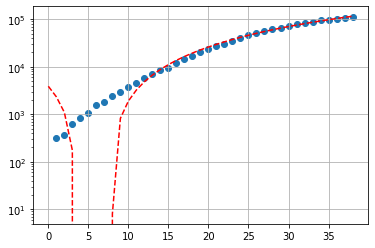

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1497
New cases registered today: 61
New cases registered today in %: 4.25
Doubling time in the last five days: 12.4
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 32.13


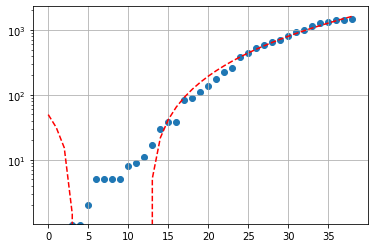

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.7683
Total cases up to today: 299
New cases registered today: 7
New cases registered today in %: 2.4
Doubling time in the last five days: 13.0
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 30.57


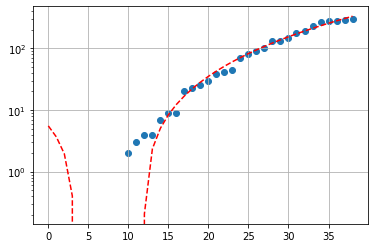

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.4637
Total cases up to today: 140
New cases registered today: 12
New cases registered today in %: 9.38
Doubling time in the last five days: 7.5
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 59.09


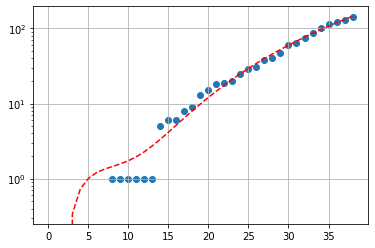

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 2.0105
Total cases up to today: 646
New cases registered today: 15
New cases registered today in %: 2.38
Doubling time in the last five days: 14.9
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 26.17


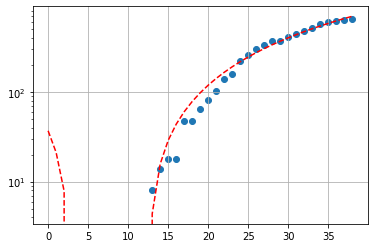

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.3296
Total cases up to today: 412
New cases registered today: 27
New cases registered today in %: 7.01
Doubling time in the last five days: 11.4
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 35.53


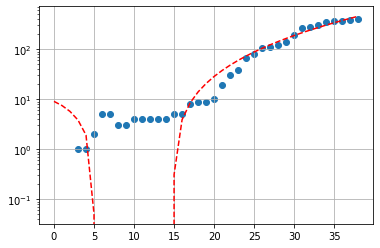

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 246
New cases registered today: 9
New cases registered today in %: 3.8
Doubling time in the last five days: 11.5
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 35.16


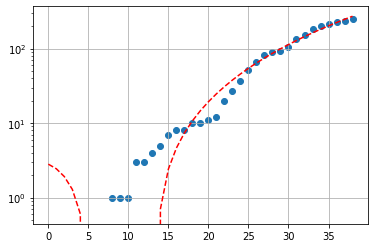

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.5909
Total cases up to today: 118
New cases registered today: 4
New cases registered today in %: 3.51
Doubling time in the last five days: 7.9
Doubling time yesterday: 4.5
Trend of new cases (in %) in the last 5 days: 55.26


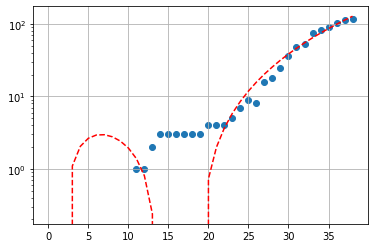

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.3453
Total cases up to today: 128
New cases registered today: 5
New cases registered today in %: 4.07
Doubling time in the last five days: 18.4
Doubling time yesterday: 15.3
Trend of new cases (in %) in the last 5 days: 20.75


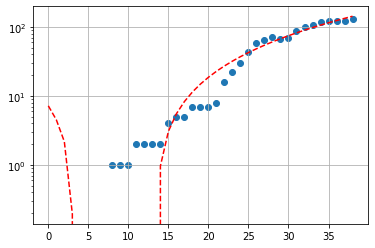

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1479
New cases registered today: 61
New cases registered today in %: 4.3
Doubling time in the last five days: 12.0
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 33.36


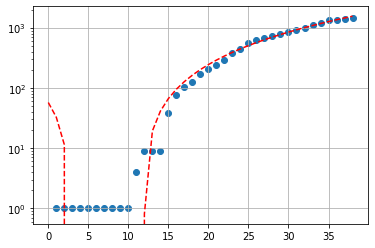

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 689
New cases registered today: 22
New cases registered today in %: 3.3
Doubling time in the last five days: 15.8
Doubling time yesterday: 11.4
Trend of new cases (in %) in the last 5 days: 24.59


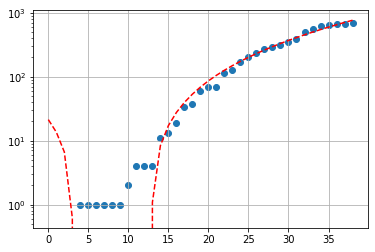

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.4029
Total cases up to today: 146
New cases registered today: 6
New cases registered today in %: 4.29
Doubling time in the last five days: 16.3
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 23.73


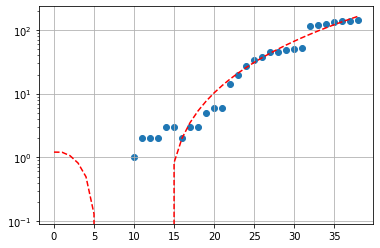

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2726
Total cases up to today: 194
New cases registered today: 6
New cases registered today in %: 3.19
Doubling time in the last five days: 15.0
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 25.97


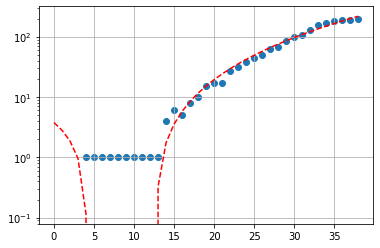

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.5354
Total cases up to today: 94
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 44.8
Doubling time yesterday: 21.5
Trend of new cases (in %) in the last 5 days: 8.05


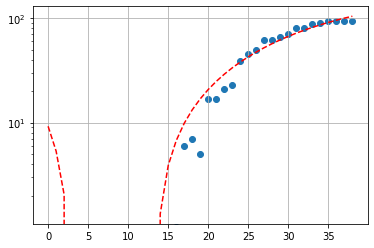

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.3737
Total cases up to today: 207
New cases registered today: 6
New cases registered today in %: 2.99
Doubling time in the last five days: 12.0
Doubling time yesterday: 9.6
Trend of new cases (in %) in the last 5 days: 33.55


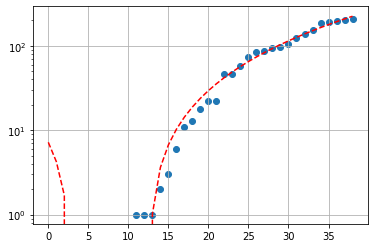

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.297
Total cases up to today: 48
New cases registered today: 4
New cases registered today in %: 9.09
Doubling time in the last five days: 16.7
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 23.08


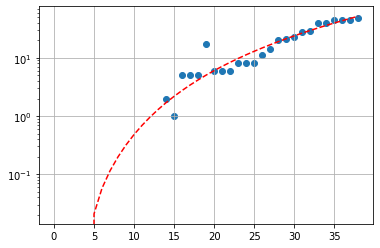

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 2294
New cases registered today: 196
New cases registered today in %: 9.34
Doubling time in the last five days: 8.6
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 49.54


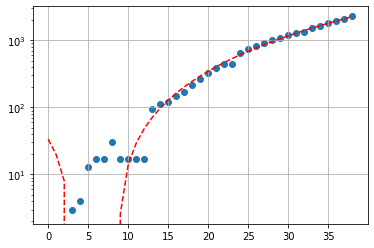

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.6848
Total cases up to today: 290
New cases registered today: 32
New cases registered today in %: 12.4
Doubling time in the last five days: 8.5
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 50.26


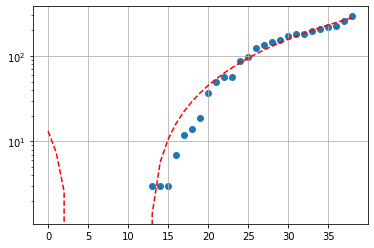

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.3039
Total cases up to today: 85
New cases registered today: 4
New cases registered today in %: 4.94
Doubling time in the last five days: 2.5
Doubling time yesterday: 2.1
Trend of new cases (in %) in the last 5 days: 304.76


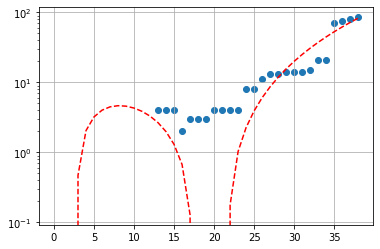

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.2759
Total cases up to today: 255
New cases registered today: 17
New cases registered today in %: 7.14
Doubling time in the last five days: 11.0
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 37.1


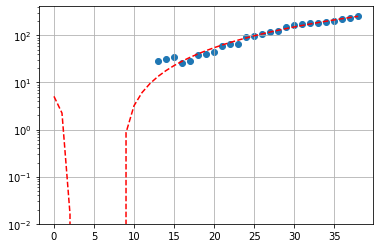

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.4117
Total cases up to today: 1279
New cases registered today: 118
New cases registered today in %: 10.16
Doubling time in the last five days: 7.9
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 54.66


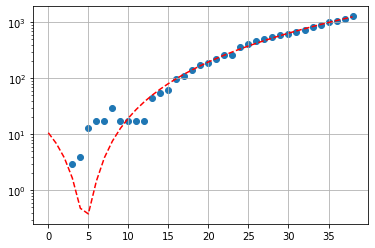

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.3485
Total cases up to today: 385
New cases registered today: 25
New cases registered today in %: 6.94
Doubling time in the last five days: 15.3
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 25.41


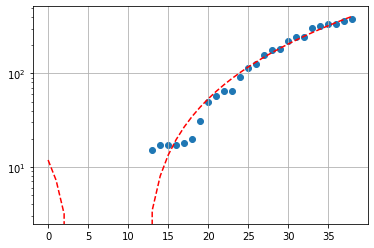

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


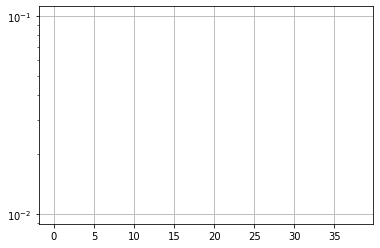

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 2.2047
Total cases up to today: 2225
New cases registered today: 141
New cases registered today in %: 6.77
Doubling time in the last five days: 10.2
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 40.29


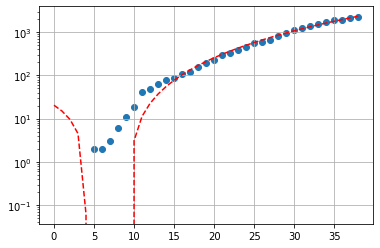

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 0.9789
Total cases up to today: 341
New cases registered today: 15
New cases registered today in %: 4.6
Doubling time in the last five days: 17.9
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 21.35


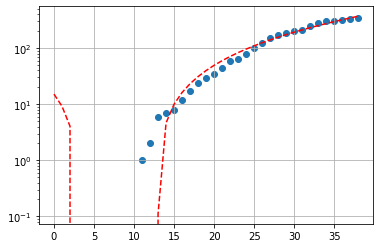

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 3.4472
Total cases up to today: 2416
New cases registered today: 119
New cases registered today in %: 5.18
Doubling time in the last five days: 15.2
Doubling time yesterday: 13.4
Trend of new cases (in %) in the last 5 days: 25.7


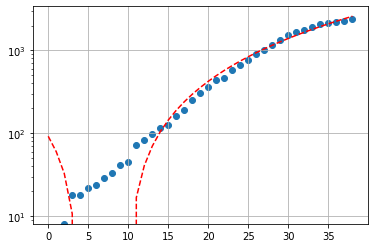

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 4.5645
Total cases up to today: 2049
New cases registered today: 44
New cases registered today in %: 2.19
Doubling time in the last five days: 22.1
Doubling time yesterday: 20.3
Trend of new cases (in %) in the last 5 days: 16.95


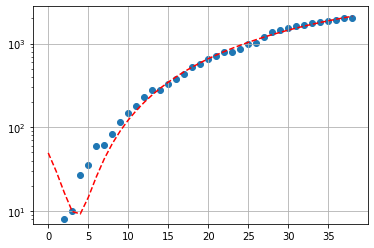

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 9.6423
Total cases up to today: 2765
New cases registered today: 49
New cases registered today in %: 1.8
Doubling time in the last five days: 23.8
Doubling time yesterday: 19.6
Trend of new cases (in %) in the last 5 days: 15.69


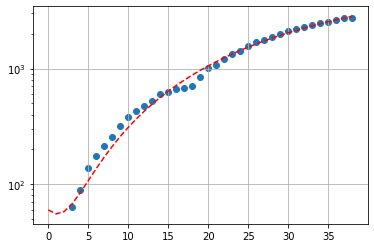

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.6019
Total cases up to today: 627
New cases registered today: 22
New cases registered today in %: 3.64
Doubling time in the last five days: 18.7
Doubling time yesterday: 16.1
Trend of new cases (in %) in the last 5 days: 20.35


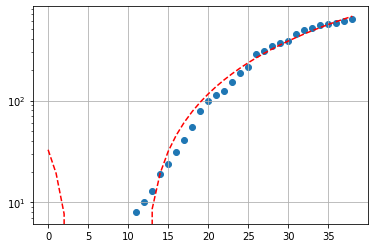

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 5.0049
Total cases up to today: 2665
New cases registered today: 112
New cases registered today in %: 4.39
Doubling time in the last five days: 12.0
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 33.52


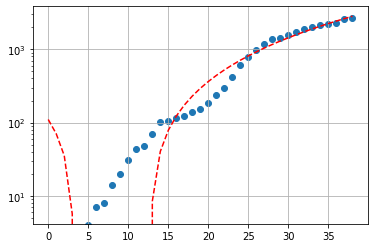

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.3232
Total cases up to today: 1456
New cases registered today: 11
New cases registered today in %: 0.76
Doubling time in the last five days: 36.2
Doubling time yesterday: 25.9
Trend of new cases (in %) in the last 5 days: 10.05


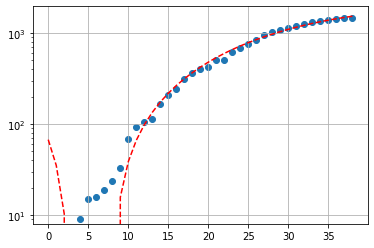

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1790
New cases registered today: 114
New cases registered today in %: 6.8
Doubling time in the last five days: 15.4
Doubling time yesterday: 14.0
Trend of new cases (in %) in the last 5 days: 25.26


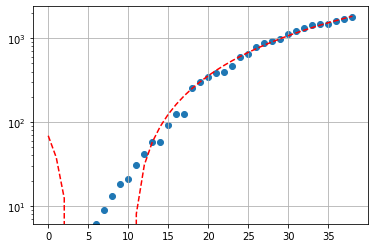

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.7876
Total cases up to today: 110
New cases registered today: 4
New cases registered today in %: 3.77
Doubling time in the last five days: 13.4
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 29.41


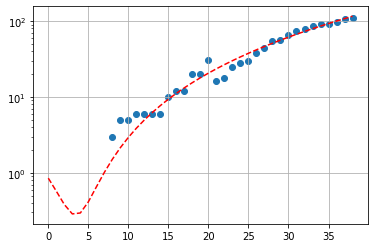

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.4132
Total cases up to today: 441
New cases registered today: 22
New cases registered today in %: 5.25
Doubling time in the last five days: 17.6
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 21.82


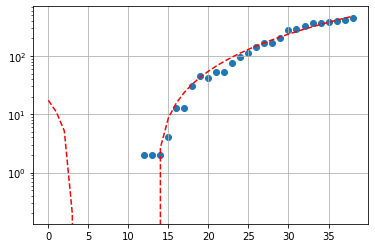

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.5481
Total cases up to today: 598
New cases registered today: 23
New cases registered today in %: 4.0
Doubling time in the last five days: 12.4
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 32.3


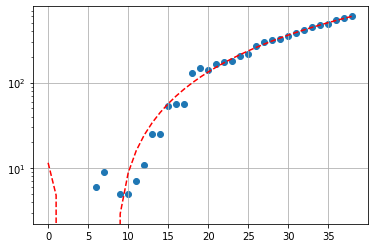

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.2061
Total cases up to today: 641
New cases registered today: 65
New cases registered today in %: 11.28
Doubling time in the last five days: 18.2
Doubling time yesterday: 20.6
Trend of new cases (in %) in the last 5 days: 20.94


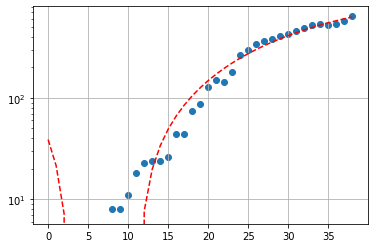

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 3414
New cases registered today: 167
New cases registered today in %: 5.14
Doubling time in the last five days: 11.0
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 37.0


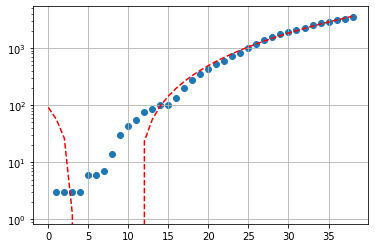

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.6774
Total cases up to today: 334
New cases registered today: 5
New cases registered today in %: 1.52
Doubling time in the last five days: 9.5
Doubling time yesterday: 6.4
Trend of new cases (in %) in the last 5 days: 43.97


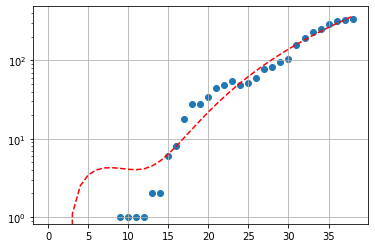

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.487
Total cases up to today: 280
New cases registered today: 8
New cases registered today in %: 2.94
Doubling time in the last five days: 13.1
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 30.23


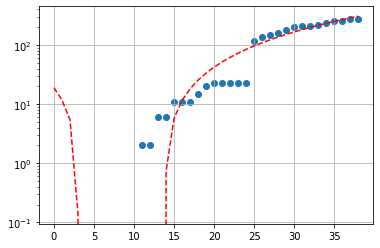

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.1943
Total cases up to today: 188
New cases registered today: -5
New cases registered today in %: -2.59
Doubling time in the last five days: 3.1
Doubling time yesterday: 2.3
Trend of new cases (in %) in the last 5 days: 203.23


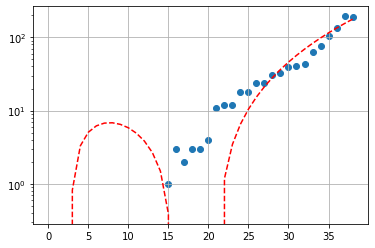

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.5496
Total cases up to today: 2393
New cases registered today: 133
New cases registered today in %: 5.88
Doubling time in the last five days: 13.2
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 30.13


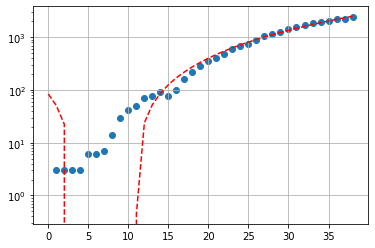

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.6865
Total cases up to today: 219
New cases registered today: 26
New cases registered today in %: 13.47
Doubling time in the last five days: 8.3
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 52.08


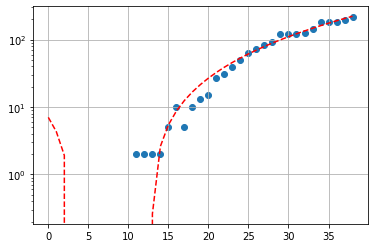

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1868
New cases registered today: 38
New cases registered today in %: 2.08
Doubling time in the last five days: 19.8
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 19.13


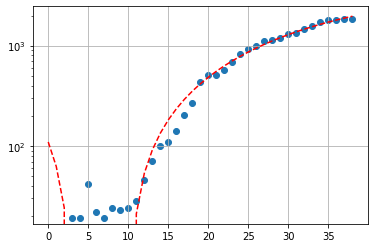

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.3564
Total cases up to today: 1153
New cases registered today: 45
New cases registered today in %: 4.06
Doubling time in the last five days: 12.8
Doubling time yesterday: 11.4
Trend of new cases (in %) in the last 5 days: 31.17


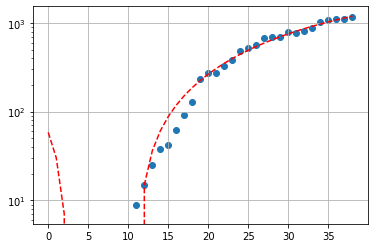

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.0226
Total cases up to today: 220
New cases registered today: -6
New cases registered today in %: -2.65
Doubling time in the last five days: -49.4
Doubling time yesterday: 63.5
Trend of new cases (in %) in the last 5 days: -6.78


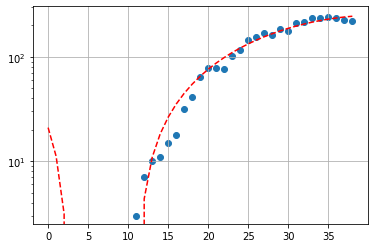

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.1328
Total cases up to today: 250
New cases registered today: 5
New cases registered today in %: 2.04
Doubling time in the last five days: 52.4
Doubling time yesterday: 24.8
Trend of new cases (in %) in the last 5 days: 6.84


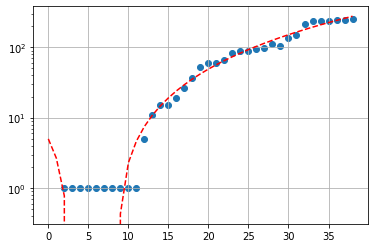

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.8769
Total cases up to today: 245
New cases registered today: -6
New cases registered today in %: -2.39
Doubling time in the last five days: 30.9
Doubling time yesterday: 29.3
Trend of new cases (in %) in the last 5 days: 11.87


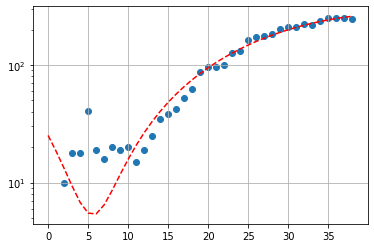

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 45071
New cases registered today: 1261
New cases registered today in %: 2.88
Doubling time in the last five days: 21.2
Doubling time yesterday: 19.0
Trend of new cases (in %) in the last 5 days: 17.78


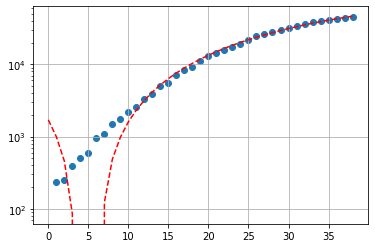

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 8.2627
Total cases up to today: 9171
New cases registered today: 132
New cases registered today in %: 1.46
Doubling time in the last five days: 36.9
Doubling time yesterday: 30.2
Trend of new cases (in %) in the last 5 days: 9.85


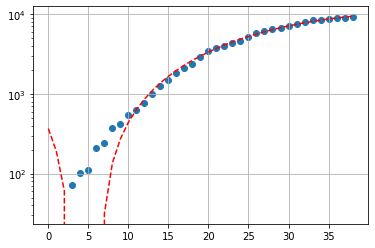

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 6.9372
Total cases up to today: 8757
New cases registered today: 159
New cases registered today in %: 1.85
Doubling time in the last five days: 26.4
Doubling time yesterday: 21.3
Trend of new cases (in %) in the last 5 days: 14.05


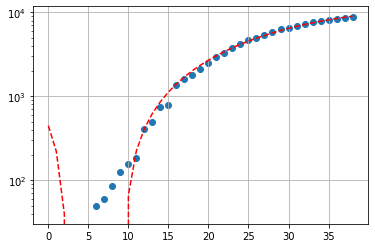

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 2.0077
Total cases up to today: 1205
New cases registered today: 48
New cases registered today in %: 4.15
Doubling time in the last five days: 12.0
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 33.44


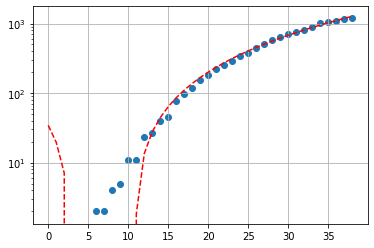

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 11.0577
Total cases up to today: 3974
New cases registered today: 33
New cases registered today in %: 0.84
Doubling time in the last five days: 35.6
Doubling time yesterday: 28.9
Trend of new cases (in %) in the last 5 days: 10.24


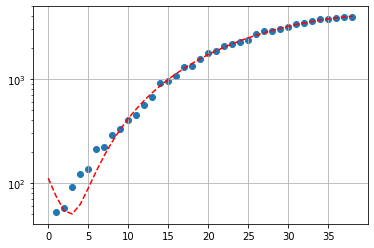

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.575
Total cases up to today: 1552
New cases registered today: 36
New cases registered today in %: 2.37
Doubling time in the last five days: 21.0
Doubling time yesterday: 15.4
Trend of new cases (in %) in the last 5 days: 17.93


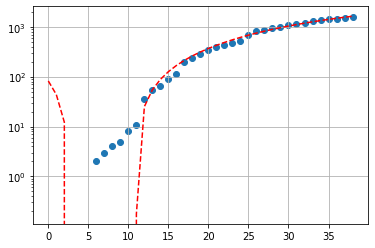

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 9.5449
Total cases up to today: 2189
New cases registered today: 32
New cases registered today in %: 1.48
Doubling time in the last five days: 45.7
Doubling time yesterday: 47.8
Trend of new cases (in %) in the last 5 days: 7.89


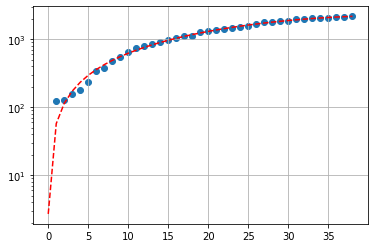

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 4.3188
Total cases up to today: 1782
New cases registered today: 46
New cases registered today in %: 2.65
Doubling time in the last five days: 18.9
Doubling time yesterday: 16.0
Trend of new cases (in %) in the last 5 days: 20.08


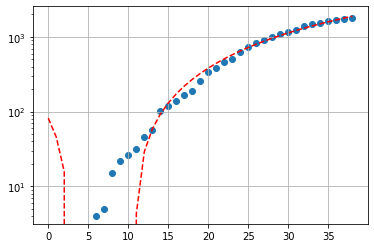

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 3.1086
Total cases up to today: 10004
New cases registered today: 482
New cases registered today in %: 5.06
Doubling time in the last five days: 13.8
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 28.54


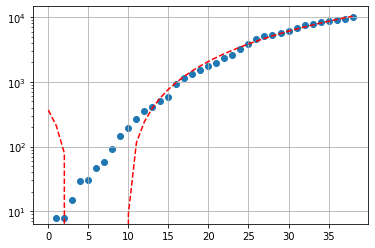

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 3.0304
Total cases up to today: 2633
New cases registered today: 90
New cases registered today in %: 3.54
Doubling time in the last five days: 14.9
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 26.22


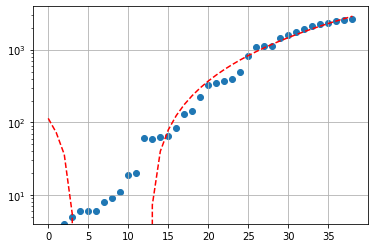

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 4.1754
Total cases up to today: 2285
New cases registered today: 105
New cases registered today in %: 4.82
Doubling time in the last five days: 17.6
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 21.74


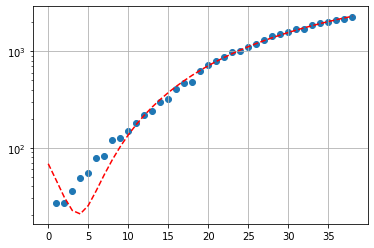

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 2.8495
Total cases up to today: 517
New cases registered today: 33
New cases registered today in %: 6.82
Doubling time in the last five days: 12.1
Doubling time yesterday: 11.9
Trend of new cases (in %) in the last 5 days: 33.25


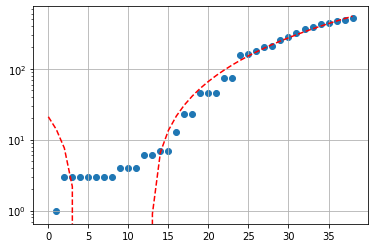

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.1258
Total cases up to today: 1002
New cases registered today: 65
New cases registered today in %: 6.94
Doubling time in the last five days: 13.0
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 30.47


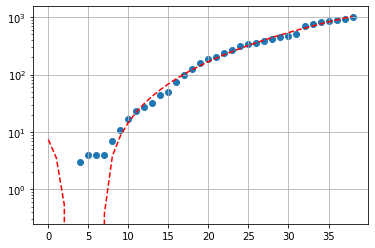

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 4011
New cases registered today: 122
New cases registered today in %: 3.14
Doubling time in the last five days: 18.1
Doubling time yesterday: 16.2
Trend of new cases (in %) in the last 5 days: 21.11


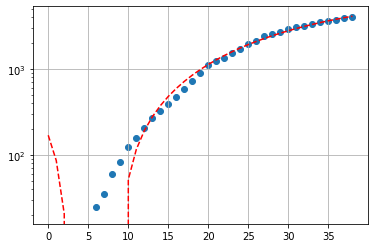

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.5542
Total cases up to today: 1211
New cases registered today: 37
New cases registered today in %: 3.15
Doubling time in the last five days: 13.9
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 28.28


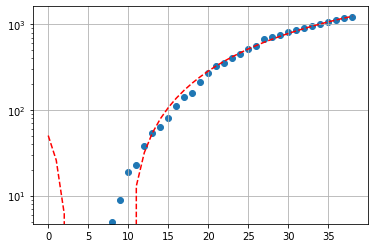

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.0838
Total cases up to today: 227
New cases registered today: 3
New cases registered today in %: 1.34
Doubling time in the last five days: 10.5
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 39.26


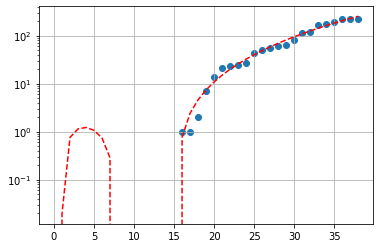

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.6243
Total cases up to today: 284
New cases registered today: 21
New cases registered today in %: 7.98
Doubling time in the last five days: 21.1
Doubling time yesterday: 28.6
Trend of new cases (in %) in the last 5 days: 17.84


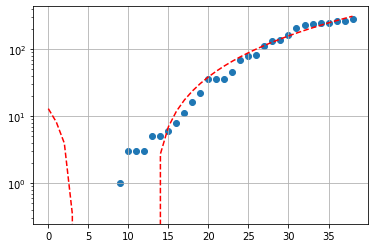

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.6713
Total cases up to today: 533
New cases registered today: 27
New cases registered today in %: 5.34
Doubling time in the last five days: 22.5
Doubling time yesterday: 16.7
Trend of new cases (in %) in the last 5 days: 16.63


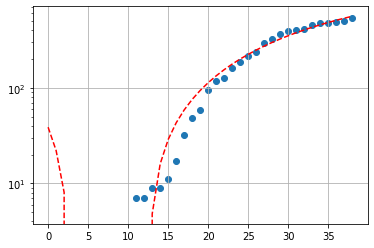

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 4.8682
Total cases up to today: 1756
New cases registered today: 34
New cases registered today in %: 1.97
Doubling time in the last five days: 22.7
Doubling time yesterday: 22.4
Trend of new cases (in %) in the last 5 days: 16.52


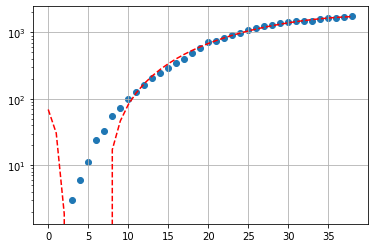

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 153
New cases registered today: 4
New cases registered today in %: 2.68
Doubling time in the last five days: 10.5
Doubling time yesterday: 8.7
Trend of new cases (in %) in the last 5 days: 39.09


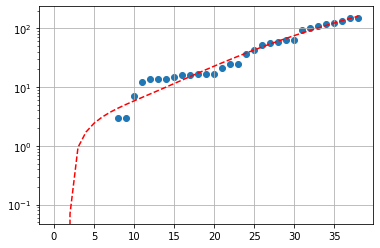

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.6321
Total cases up to today: 142
New cases registered today: 3
New cases registered today in %: 2.16
Doubling time in the last five days: 9.1
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 46.39


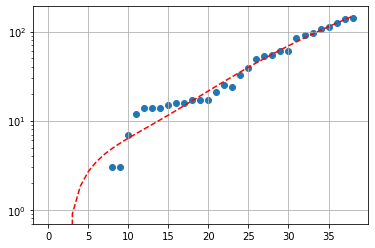

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.1282
Total cases up to today: 11
New cases registered today: 1
New cases registered today in %: 10.0
Doubling time in the last five days: -20.7
Doubling time yesterday: 32.9
Trend of new cases (in %) in the last 5 days: -15.38


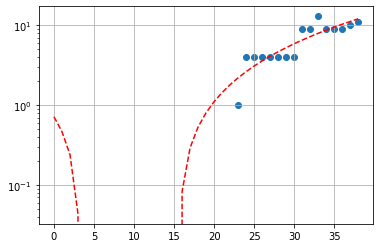

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 10135
New cases registered today: 552
New cases registered today in %: 5.76
Doubling time in the last five days: 11.5
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 35.28


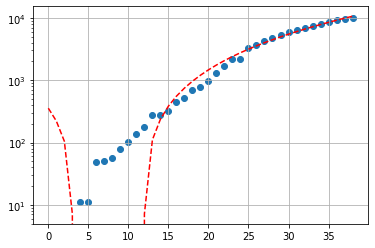

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 3.3469
Total cases up to today: 1428
New cases registered today: 50
New cases registered today in %: 3.63
Doubling time in the last five days: 19.6
Doubling time yesterday: 15.8
Trend of new cases (in %) in the last 5 days: 19.3


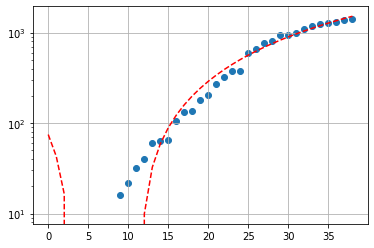

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 2.3122
Total cases up to today: 501
New cases registered today: 40
New cases registered today in %: 8.68
Doubling time in the last five days: 7.6
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 57.55


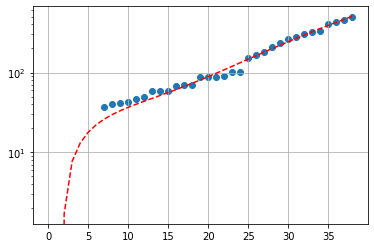

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 2.9291
Total cases up to today: 523
New cases registered today: 20
New cases registered today in %: 3.98
Doubling time in the last five days: 12.8
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 31.08


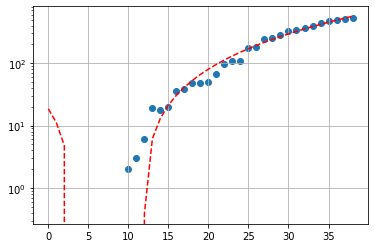

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.4021
Total cases up to today: 826
New cases registered today: 48
New cases registered today in %: 6.17
Doubling time in the last five days: 8.8
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 48.03


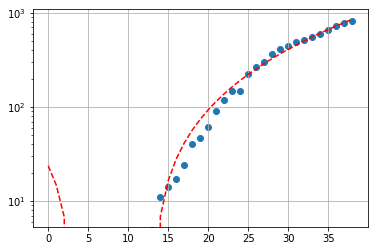

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 2.4369
Total cases up to today: 902
New cases registered today: 48
New cases registered today in %: 5.62
Doubling time in the last five days: 10.9
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 37.29


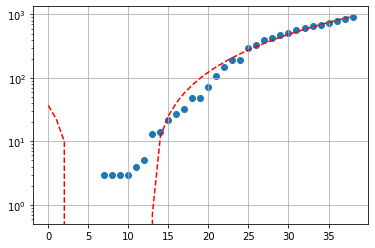

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 2.1911
Total cases up to today: 4991
New cases registered today: 280
New cases registered today in %: 5.94
Doubling time in the last five days: 11.2
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 36.44


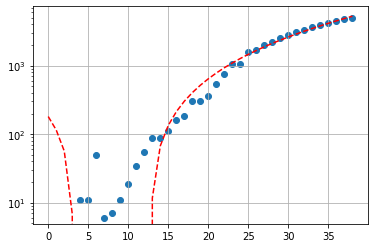

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 2.7808
Total cases up to today: 444
New cases registered today: 34
New cases registered today in %: 8.29
Doubling time in the last five days: 9.5
Doubling time yesterday: 9.8
Trend of new cases (in %) in the last 5 days: 44.16


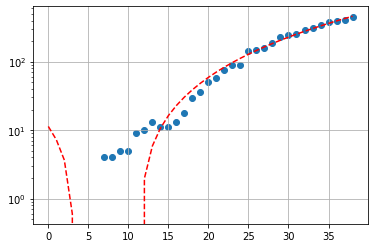

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 2.9908
Total cases up to today: 520
New cases registered today: 32
New cases registered today in %: 6.56
Doubling time in the last five days: 12.8
Doubling time yesterday: 11.2
Trend of new cases (in %) in the last 5 days: 30.98


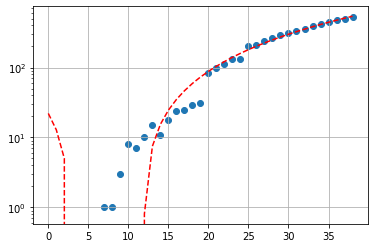

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 2052
New cases registered today: 131
New cases registered today in %: 6.82
Doubling time in the last five days: 9.1
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 46.57


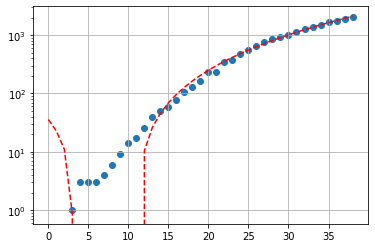

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.5555
Total cases up to today: 700
New cases registered today: 45
New cases registered today in %: 6.87
Doubling time in the last five days: 8.7
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 49.25


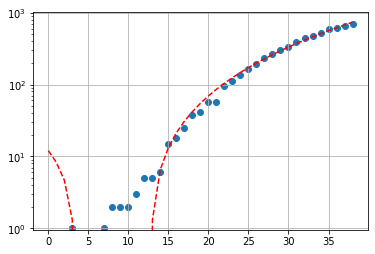

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.321
Total cases up to today: 126
New cases registered today: 10
New cases registered today in %: 8.62
Doubling time in the last five days: 12.7
Doubling time yesterday: 15.0
Trend of new cases (in %) in the last 5 days: 31.25


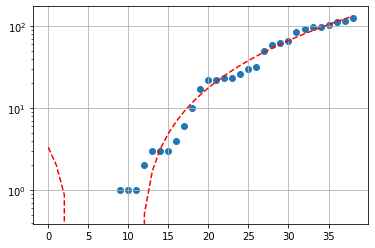

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.5238
Total cases up to today: 208
New cases registered today: 17
New cases registered today in %: 8.9
Doubling time in the last five days: 10.2
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 40.54


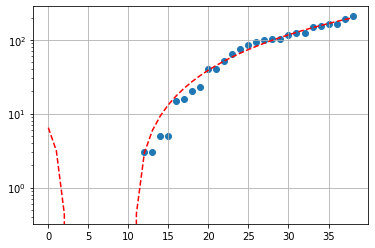

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.7987
Total cases up to today: 502
New cases registered today: 12
New cases registered today in %: 2.45
Doubling time in the last five days: 10.0
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 41.41


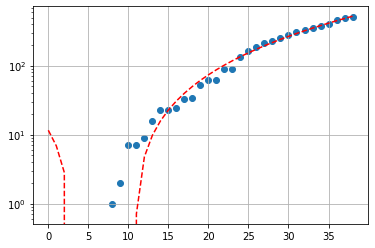

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.4401
Total cases up to today: 353
New cases registered today: 32
New cases registered today in %: 9.97
Doubling time in the last five days: 8.9
Doubling time yesterday: 8.6
Trend of new cases (in %) in the last 5 days: 47.7


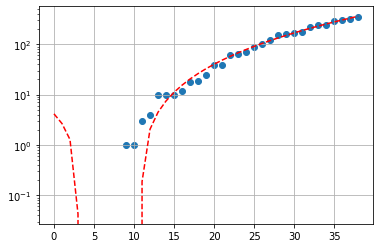

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.2794
Total cases up to today: 163
New cases registered today: 15
New cases registered today in %: 10.14
Doubling time in the last five days: 6.2
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 75.27


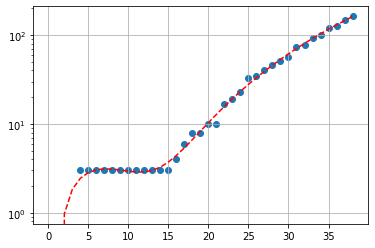

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 794
New cases registered today: 49
New cases registered today in %: 6.58
Doubling time in the last five days: 14.4
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 27.24


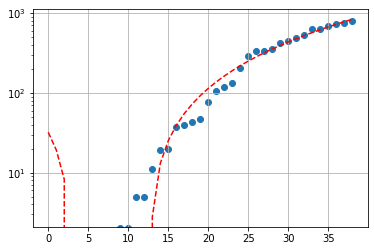

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.2249
Total cases up to today: 126
New cases registered today: 10
New cases registered today in %: 8.62
Doubling time in the last five days: 13.2
Doubling time yesterday: 10.4
Trend of new cases (in %) in the last 5 days: 29.9


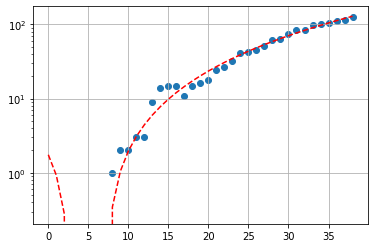

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3844
Total cases up to today: 60
New cases registered today: 1
New cases registered today in %: 1.69
Doubling time in the last five days: 50.2
Doubling time yesterday: 27.4
Trend of new cases (in %) in the last 5 days: 7.14


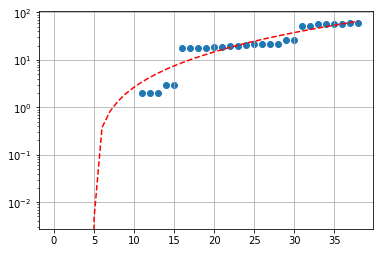

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.112
Total cases up to today: 18
New cases registered today: 3
New cases registered today in %: 20.0
Doubling time in the last five days: 5.0
Doubling time yesterday: 6.8
Trend of new cases (in %) in the last 5 days: 100.0


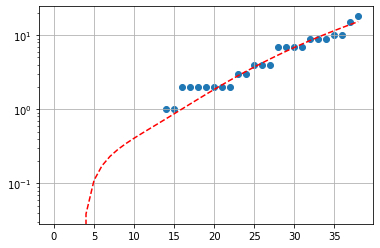

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.585
Total cases up to today: 528
New cases registered today: 31
New cases registered today in %: 6.24
Doubling time in the last five days: 13.3
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 29.73


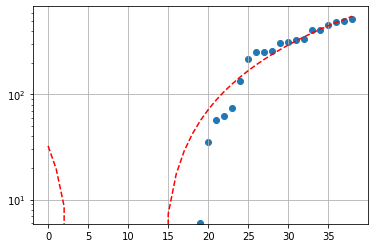

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1791
New cases registered today: 73
New cases registered today in %: 4.25
Doubling time in the last five days: 12.6
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 31.79


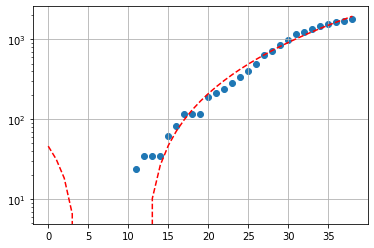

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2217
Total cases up to today: 98
New cases registered today: 2
New cases registered today in %: 2.08
Doubling time in the last five days: 6.6
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 68.97


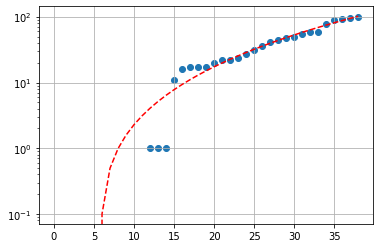

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.2966
Total cases up to today: 80
New cases registered today: 4
New cases registered today in %: 5.26
Doubling time in the last five days: 10.2
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 40.35


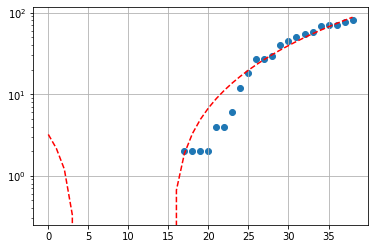

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.4886
Total cases up to today: 544
New cases registered today: 34
New cases registered today in %: 6.67
Doubling time in the last five days: 10.2
Doubling time yesterday: 10.4
Trend of new cases (in %) in the last 5 days: 40.57


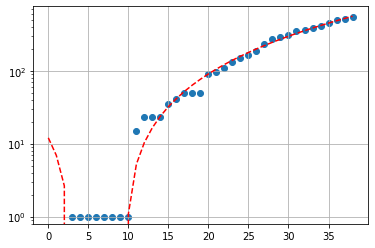

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.4162
Total cases up to today: 238
New cases registered today: 14
New cases registered today in %: 6.25
Doubling time in the last five days: 10.0
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 41.67


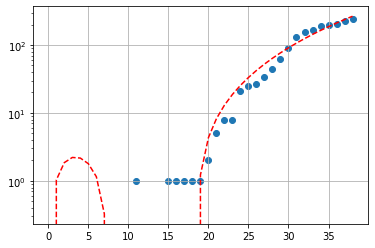

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.5073
Total cases up to today: 323
New cases registered today: 4
New cases registered today in %: 1.25
Doubling time in the last five days: 23.7
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 15.77


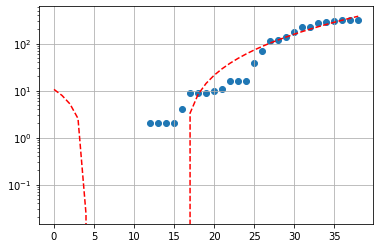

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2224
Total cases up to today: 282
New cases registered today: 6
New cases registered today in %: 2.17
Doubling time in the last five days: 17.8
Doubling time yesterday: 14.7
Trend of new cases (in %) in the last 5 days: 21.55


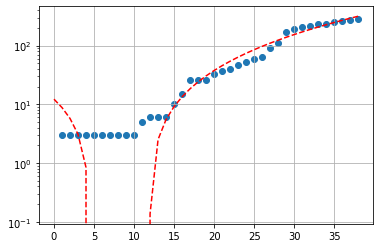

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.14
Total cases up to today: 45
New cases registered today: 1
New cases registered today in %: 2.27
Doubling time in the last five days: 10.2
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 40.62


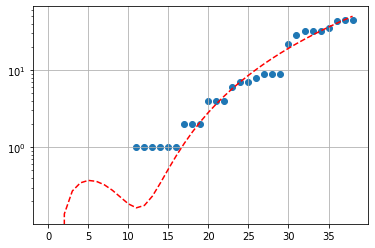

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2507
Total cases up to today: 101
New cases registered today: 3
New cases registered today in %: 3.06
Doubling time in the last five days: 18.8
Doubling time yesterday: 16.1
Trend of new cases (in %) in the last 5 days: 20.24


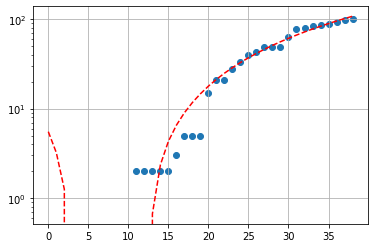

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.1841
Total cases up to today: 80
New cases registered today: 5
New cases registered today in %: 6.67
Doubling time in the last five days: 13.6
Doubling time yesterday: 16.8
Trend of new cases (in %) in the last 5 days: 29.03


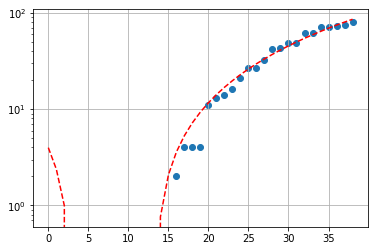

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 5273
New cases registered today: 406
New cases registered today in %: 8.34
Doubling time in the last five days: 10.7
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 38.15


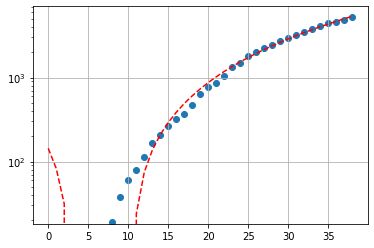

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.0367
Total cases up to today: 357
New cases registered today: 14
New cases registered today in %: 4.08
Doubling time in the last five days: 12.7
Doubling time yesterday: 12.5
Trend of new cases (in %) in the last 5 days: 31.25


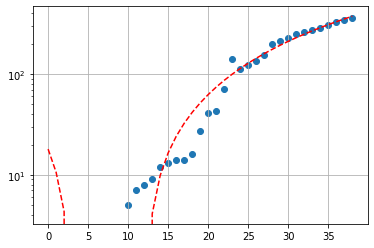

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.3988
Total cases up to today: 1419
New cases registered today: 261
New cases registered today in %: 22.54
Doubling time in the last five days: 6.8
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 65.96


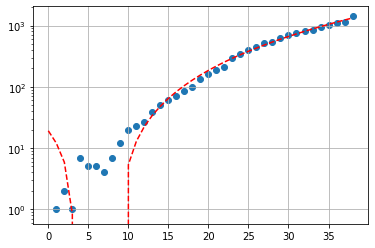

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.1836
Total cases up to today: 264
New cases registered today: 1
New cases registered today in %: 0.38
Doubling time in the last five days: 28.7
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 12.82


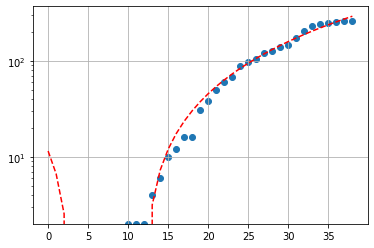

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.8923
Total cases up to today: 301
New cases registered today: 6
New cases registered today in %: 2.03
Doubling time in the last five days: 11.1
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 36.82


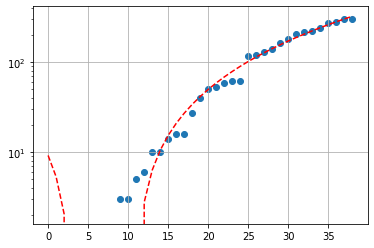

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 2.0562
Total cases up to today: 802
New cases registered today: 31
New cases registered today in %: 4.02
Doubling time in the last five days: 13.3
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 29.77


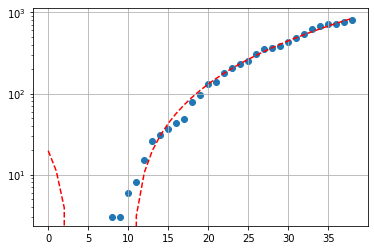

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 3.276
Total cases up to today: 644
New cases registered today: 33
New cases registered today in %: 5.4
Doubling time in the last five days: 11.0
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 37.02


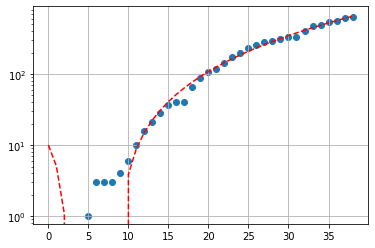

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.2208
Total cases up to today: 515
New cases registered today: 24
New cases registered today in %: 4.89
Doubling time in the last five days: 13.4
Doubling time yesterday: 12.7
Trend of new cases (in %) in the last 5 days: 29.4


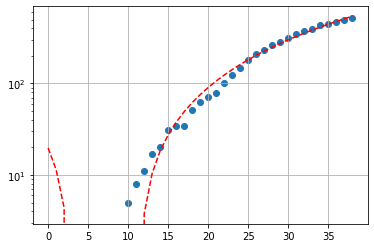

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.1856
Total cases up to today: 346
New cases registered today: 13
New cases registered today in %: 3.9
Doubling time in the last five days: 23.2
Doubling time yesterday: 20.4
Trend of new cases (in %) in the last 5 days: 16.11


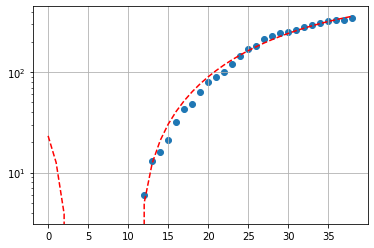

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.1429
Total cases up to today: 291
New cases registered today: 1
New cases registered today in %: 0.34
Doubling time in the last five days: 11.8
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 34.1


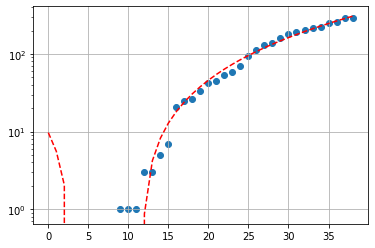

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.2447
Total cases up to today: 334
New cases registered today: 22
New cases registered today in %: 7.05
Doubling time in the last five days: 9.9
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 42.13


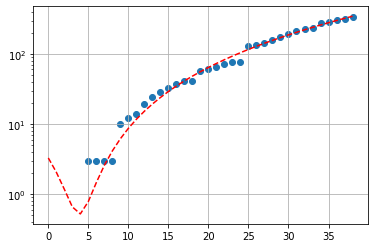

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 3.7189
Total cases up to today: 2003
New cases registered today: 133
New cases registered today in %: 7.11
Doubling time in the last five days: 12.1
Doubling time yesterday: 11.7
Trend of new cases (in %) in the last 5 days: 33.09


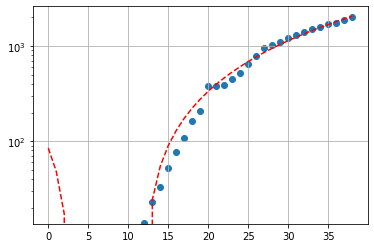

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1090
New cases registered today: 32
New cases registered today in %: 3.02
Doubling time in the last five days: 23.7
Doubling time yesterday: 16.1
Trend of new cases (in %) in the last 5 days: 15.71


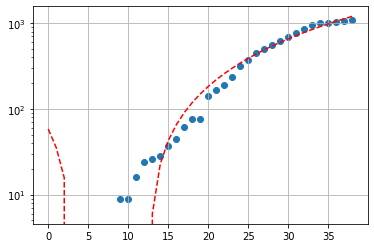

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.2775
Total cases up to today: 844
New cases registered today: 22
New cases registered today in %: 2.68
Doubling time in the last five days: 23.7
Doubling time yesterday: 15.6
Trend of new cases (in %) in the last 5 days: 15.78


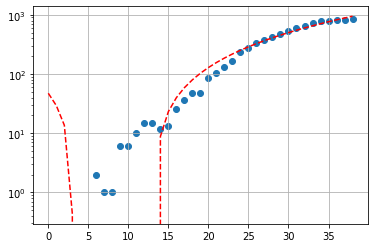

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.0779
Total cases up to today: 246
New cases registered today: 10
New cases registered today in %: 4.24
Doubling time in the last five days: 24.1
Doubling time yesterday: 18.2
Trend of new cases (in %) in the last 5 days: 15.49


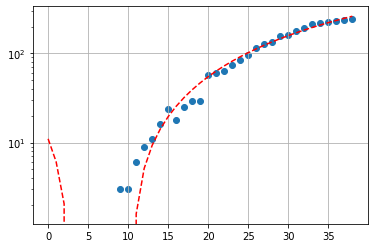

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 5.2647
Total cases up to today: 668
New cases registered today: 37
New cases registered today in %: 5.86
Doubling time in the last five days: 12.9
Doubling time yesterday: 10.4
Trend of new cases (in %) in the last 5 days: 30.72


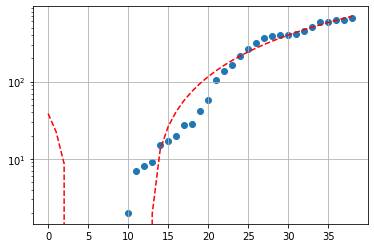

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 9866
New cases registered today: 499
New cases registered today in %: 5.33
Doubling time in the last five days: 13.7
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 28.7


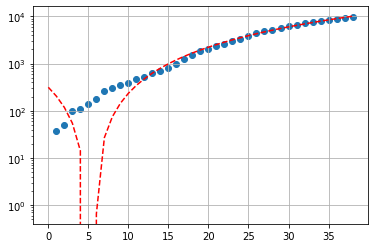

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 2.3666
Total cases up to today: 487
New cases registered today: 27
New cases registered today in %: 5.87
Doubling time in the last five days: 12.3
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 32.7


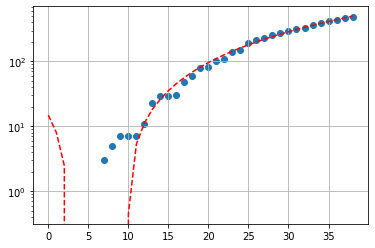

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.6584
Total cases up to today: 2489
New cases registered today: 121
New cases registered today in %: 5.11
Doubling time in the last five days: 16.2
Doubling time yesterday: 15.4
Trend of new cases (in %) in the last 5 days: 23.89


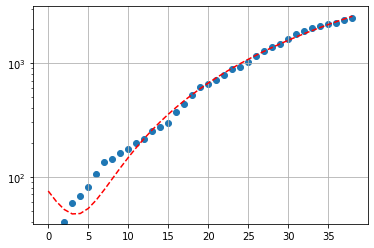

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.6371
Total cases up to today: 152
New cases registered today: 12
New cases registered today in %: 8.57
Doubling time in the last five days: 15.8
Doubling time yesterday: 25.2
Trend of new cases (in %) in the last 5 days: 24.59


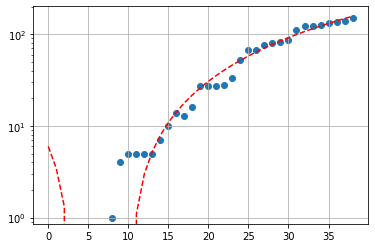

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.8127
Total cases up to today: 1606
New cases registered today: 52
New cases registered today in %: 3.35
Doubling time in the last five days: 20.8
Doubling time yesterday: 20.3
Trend of new cases (in %) in the last 5 days: 18.18


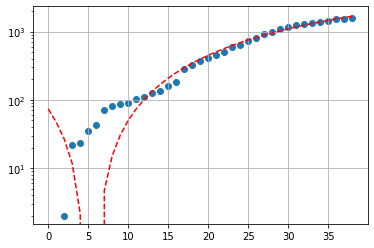

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.5136
Total cases up to today: 1293
New cases registered today: 62
New cases registered today in %: 5.04
Doubling time in the last five days: 14.6
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 26.89


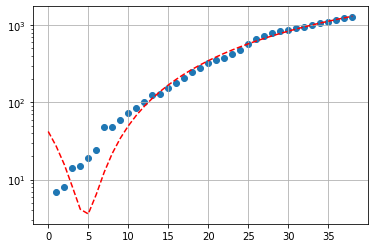

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.6097
Total cases up to today: 2405
New cases registered today: 118
New cases registered today in %: 5.16
Doubling time in the last five days: 11.0
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 37.12


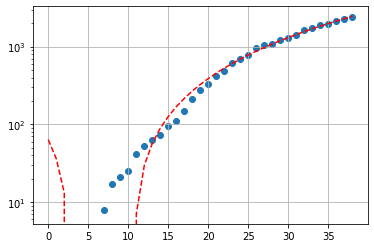

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.6576
Total cases up to today: 1434
New cases registered today: 107
New cases registered today in %: 8.06
Doubling time in the last five days: 10.7
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 38.42


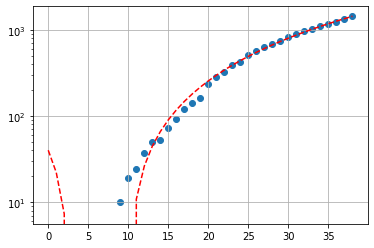

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')